In [1]:
import sys
sys.path.append("..")

import optuna
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import optuna
import pandas as pd
import numpy as np

c:\Users\dzahariev\Desktop\Thesis\Thesis\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
logs_path = "sqlite:///C:/Users/dzahariev/Desktop/Thesis/Thesis/experiments/hyperparameter_search/"

logname1 = "study_srnn_mnist_20250609_205015.db"
logname2 = "study_srnn_cifar10_20250609_205039.db"
logname3 = "study_spikformer_mnist_20250610_014324.db"
logname4 = "study_spikformer_cifar10_20250610_145021.db"

study_srnn_mnist = optuna.load_study(study_name="ce_ss_loss_optimization", storage = f"{logs_path}/{logname1}")
study_srnn_cifar10 = optuna.load_study(study_name="ce_ss_loss_optimization", storage = f"{logs_path}/{logname2}")
study_spikformer_mnist = optuna.load_study(study_name="ce_ss_loss_optimization", storage = f"{logs_path}/{logname3}")
study_spikformer_cifar10 = optuna.load_study(study_name="ce_ss_loss_optimization", storage = f"{logs_path}/{logname4}")

experiments = [
    (study_srnn_mnist, 'ConvSTAL-SRNN-MNIST'),
    (study_srnn_cifar10, 'ConvSTAL-SRNN-CIFAR10'),
    (study_spikformer_mnist, 'ConvSTAL-PS-Spikformer-MNIST'),
    (study_spikformer_cifar10, 'ConvSTAL-PS-Spikformer-CIFAR10')
]

In [3]:
def get_pareto_params(study):
    """Extract omega values and metrics for Pareto-optimal solutions."""
    pareto_trials = study.best_trials
    omegas = [t.params['omega'] for t in pareto_trials]
    accuracies = [t.values[0] for t in pareto_trials]
    spikes = [t.values[1] for t in pareto_trials]
    
    # Sort by spike density for consistent plotting
    sorted_data = sorted(zip(spikes, accuracies, omegas))
    spikes, accuracies, omegas = zip(*sorted_data)
    
    return omegas, accuracies, spikes

def get_all_trials_data(study):
    """Extract Pareto-optimal and dominated solutions from study."""
    pareto_trials = study.best_trials
    pareto_accuracies = [t.values[0] for t in pareto_trials]
    pareto_spikes = [t.values[1] for t in pareto_trials]
    
    all_trials = [(t.values[0], t.values[1]) for t in study.trials if t.values is not None]
    dominated = [(a, s) for a, s in all_trials if s not in pareto_spikes or a not in pareto_accuracies]
    dominated_accuracies, dominated_spikes = zip(*dominated) if dominated else ([], [])
    
    # Sort Pareto front data
    pareto_data = sorted(zip(pareto_spikes, pareto_accuracies))
    pareto_spikes, pareto_accuracies = zip(*pareto_data)
    
    return pareto_accuracies, pareto_spikes, dominated_accuracies, dominated_spikes

def add_subplot_traces(fig, study, name, row, col, color):
    """Add Pareto front and dominated points to subplot."""
    acc, spikes, dom_acc, dom_spikes = get_all_trials_data(study)
    
    # Add dominated points
    if dom_spikes:  # Only add if there are dominated points
        fig.add_trace(
            go.Scatter(x=dom_spikes, y=dom_acc, mode='markers',
                      name=f'Dominated solutions',
                      marker=dict(color='black', size=5, opacity=0.5),
                      legendgroup=name,
                      legendgrouptitle_text=name,
                      showlegend=True),
            row=row, col=col
        )
    
    # Add Pareto front
    fig.add_trace(
        go.Scatter(x=spikes, y=acc, mode='lines+markers',
                  name=f'Pareto front',
                  line=dict(color=color),
                  legendgroup=name,
                  showlegend=True),
        row=row, col=col
    )

In [4]:
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('ConvSTAL-SRNN-MNIST', 'ConvSTAL-SRNN-CIFAR10', 
                   'ConvSTAL-PS-Spikformer-MNIST', 'ConvSTAL-PS-Spikformer-CIFAR10'),
    horizontal_spacing=0.12,
    vertical_spacing=0.12
)

plots = [
    (*experiments[0], 1, 1, 'blue'),
    (*experiments[1], 1, 2, 'red'),
    (*experiments[2], 2, 1, 'green'),
    (*experiments[3], 2, 2, 'purple')
]

# Add all subplots
for study, name, row, col, color in plots:
    add_subplot_traces(fig, study, name, row, col, color)

# Update layout and axes labels
for i in range(1, 5):
    row, col = (i-1)//2 + 1, (i-1)%2 + 1
    fig.update_xaxes(title_text="Spike Density", row=row, col=col)
    fig.update_yaxes(title_text="Accuracy", row=row, col=col)

# Final layout update
fig.update_layout(
    height=800, width=1100,
    showlegend=True,
    legend=dict(
        orientation="h",
        yanchor="top",
        y=-0.1,
        xanchor="center",
        x=0.5,
        font=dict(size=14),
        tracegroupgap=5
    ),
    margin=dict(t=40, b=0),
    title_font=dict(size=2)
)

fig.show()

In [5]:
def get_pareto_front_data(study, model_name):
    """Get all points on the Pareto front with their parameters."""
    trials = study.best_trials
    
    # Sort trials by spike density for better readability
    trials = sorted(trials, key=lambda t: t.values[1])  # Sort by spike density
    
    data = []
    for trial in trials:
        data.append({
            'Model': model_name,
            'ω': f"{trial.params['omega']:.6f}",
            'c': f"{trial.params['concentration_weight']:.6f}",
            'Accuracy': f"{trial.values[0]*100:.2f}%",
            'Spike Density': f"{trial.values[1]:.4f}"
        })
    
    return data

# Get Pareto front data for each experiment
all_data = []


for study, name in experiments:
    print(f"/n{name} Pareto Front:")
    data = get_pareto_front_data(study, name)
    all_data.extend(data)
    
    # Create and display DataFrame for this experiment
    df = pd.DataFrame(data)
    
    # sort by spike density
    df = df.sort_values(by='Spike Density')
    
    display(df.style
           .set_properties(**{'text-align': 'left'})
           .set_table_styles([
               {'selector': 'th', 'props': [('text-align', 'left'), ('font-weight', 'bold')]},
               {'selector': '', 'props': [('border', '1px solid black')]},
               {'selector': 'th,td', 'props': [('padding', '8px')]}
           ])
           .hide(axis='index'))


/nConvSTAL-SRNN-MNIST Pareto Front:


Model,ω,c,Accuracy,Spike Density
ConvSTAL-SRNN-MNIST,0.000486,5.809605,93.07%,0.0049
ConvSTAL-SRNN-MNIST,0.000380,0.781559,94.20%,0.0051
ConvSTAL-SRNN-MNIST,0.000258,3.576088,94.49%,0.0066
ConvSTAL-SRNN-MNIST,0.000228,0.455820,95.03%,0.0073
ConvSTAL-SRNN-MNIST,0.000202,0.243836,95.07%,0.0083
ConvSTAL-SRNN-MNIST,0.000146,0.404360,95.32%,0.0103
ConvSTAL-SRNN-MNIST,0.000138,0.126446,95.49%,0.0111
ConvSTAL-SRNN-MNIST,0.000038,8.775846,95.77%,0.0373
ConvSTAL-SRNN-MNIST,0.000035,0.627759,96.02%,0.0422
ConvSTAL-SRNN-MNIST,0.000032,0.408155,96.09%,0.0449


/nConvSTAL-SRNN-CIFAR10 Pareto Front:


Model,ω,c,Accuracy,Spike Density
ConvSTAL-SRNN-CIFAR10,0.000322,3.517105,45.63%,0.0032
ConvSTAL-SRNN-CIFAR10,0.000304,0.513950,46.45%,0.0035
ConvSTAL-SRNN-CIFAR10,0.000287,2.072612,47.28%,0.0037
ConvSTAL-SRNN-CIFAR10,0.000297,0.240749,47.56%,0.0042
ConvSTAL-SRNN-CIFAR10,0.000060,0.903964,48.95%,0.0221
ConvSTAL-SRNN-CIFAR10,0.000041,1.044866,50.72%,0.0317
ConvSTAL-SRNN-CIFAR10,0.000035,5.090004,50.81%,0.0359
ConvSTAL-SRNN-CIFAR10,0.000016,2.558919,50.94%,0.0560
ConvSTAL-SRNN-CIFAR10,0.000011,0.149043,51.64%,0.0892
ConvSTAL-SRNN-CIFAR10,0.000007,1.719923,51.95%,0.1204


/nConvSTAL-PS-Spikformer-MNIST Pareto Front:


Model,ω,c,Accuracy,Spike Density
ConvSTAL-PS-Spikformer-MNIST,0.000440,0.683634,97.09%,0.0191
ConvSTAL-PS-Spikformer-MNIST,0.000465,7.576043,97.81%,0.0205
ConvSTAL-PS-Spikformer-MNIST,0.000309,0.679316,97.93%,0.0374
ConvSTAL-PS-Spikformer-MNIST,0.000241,0.657531,98.22%,0.0515
ConvSTAL-PS-Spikformer-MNIST,0.000187,2.586043,98.33%,0.0825
ConvSTAL-PS-Spikformer-MNIST,0.000063,8.809531,98.42%,0.2534
ConvSTAL-PS-Spikformer-MNIST,0.000072,5.936923,98.46%,0.2585
ConvSTAL-PS-Spikformer-MNIST,0.000045,0.924930,98.72%,0.3623
ConvSTAL-PS-Spikformer-MNIST,0.000032,0.210550,98.90%,0.4262
ConvSTAL-PS-Spikformer-MNIST,0.000029,5.156634,98.91%,0.4702


/nConvSTAL-PS-Spikformer-CIFAR10 Pareto Front:


Model,ω,c,Accuracy,Spike Density
ConvSTAL-PS-Spikformer-CIFAR10,0.000430,3.669165,72.36%,0.0864
ConvSTAL-PS-Spikformer-CIFAR10,0.000444,0.280315,73.76%,0.0871
ConvSTAL-PS-Spikformer-CIFAR10,0.000287,3.823839,74.21%,0.1483
ConvSTAL-PS-Spikformer-CIFAR10,0.000261,1.193656,74.75%,0.1562
ConvSTAL-PS-Spikformer-CIFAR10,0.000227,5.724930,75.15%,0.2255
ConvSTAL-PS-Spikformer-CIFAR10,0.000165,0.390717,75.46%,0.3453
ConvSTAL-PS-Spikformer-CIFAR10,0.000146,0.227388,76.02%,0.3745
ConvSTAL-PS-Spikformer-CIFAR10,0.000055,1.175782,76.86%,0.6157


In [48]:
def plot_importance(metric_id, metric_name):
    fig, axes = plt.subplots(2, 2, figsize=(8, 4))
    fig.suptitle(f'Hyperparameter Importance for {metric_name}')
    axes = axes.flatten()

    # Plot for each experiment
    for ax, (study, name) in zip(axes, experiments):
        # Calculate importance scores
        importances = optuna.importance.get_param_importances(study, target=lambda t: t.values[metric_id])
        
        params = list(importances.keys())
        scores = list(importances.values())
        
        y_pos = np.arange(len(params))
        bars = ax.barh(y_pos, scores)
        
        ax.set_yticks(y_pos)
        ax.set_yticklabels(['c' if p == 'concentration_weight' else 'omega' for p in params])
        ax.set_xlabel('Importance Score')
        ax.set_title(name)
        
        for i, bar in enumerate(bars):
            width = bar.get_width()
            ax.text(width, bar.get_y() + bar.get_height()/2,
                    f'{width:.3f}', 
                    ha='left', va='center')

    plt.tight_layout()
    plt.show()


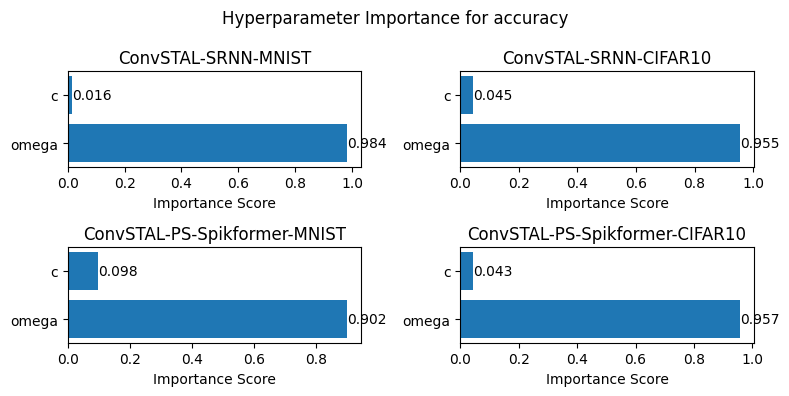

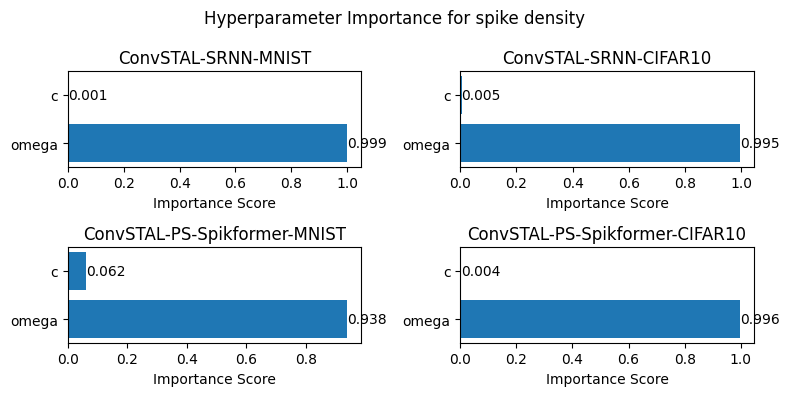

In [49]:
plot_importance(0, 'accuracy')
plot_importance(1, 'spike density')

In [ ]:
## Chosen weights

# Spikformer_mnist
# omega = 0.000309	
# c = 0.679316
# saved model path: experiments/thesis_hyperparameter_search_spikformer_mnist/dymo78zm/checkpoints/epoch=9-step=3760.ckpt

# Spikformer_cifar10
# omega = 0.000444		
# c = 0.280315
# saved model path: experiments/thesis_hyperparameter_search_spikformer_cifar10/298swbe8/checkpoints/epoch=9-step=3130.ckpt

# SRNN_mnist
# omega = 0.000138	
# c = 0.126446
# saved model path: experiments\thesis_hyperparameter_search_srnn_mnist\zfc1310z\checkpoints\epoch=4-step=1880.ckpt

# SRNN_cifar10
# omega = 0.000035	
# c = 0.627759
# saved model path: experiments\thesis_hyperparameter_search_srnn_cifar10\8a1y4lr1\checkpoints\epoch=4-step=1565.ckpt
